# QEC Dual Rail Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json

from slab import AttrDict
from slab.datamanagement import SlabFile
from fitting.fit_display_classes import GeneralFitting
from fitting.fit_display import *
import fitting.fitting as fitter

# -- Plot style ---------------------------------------------------------------
plt.rcParams.update({
    'figure.figsize': [8, 5],
    'font.size': 13,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.6,
    'legend.frameon': False,
    'legend.fontsize': 11,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
})

# -- Color palette (reuse across all plots) -----------------------------------
COLORS = {
    'mode1': '#4C72B0',    # muted blue
    'mode2': '#DD8452',    # muted orange
    'dual_rail': '#55A868', # muted green
}
alpha_plot = 0.7

Importing all classes from  D:\python\multimode_expts\experiments\dual_rail
Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'mock_hardware.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']


In [2]:
storage_modes = [1, 2, 3, 4, 6, 7]
dual_rail_modes = [[1, 3], [2, 4], [6, 7]]

# Data Paths

In [3]:
experiment_name = '250119_qec'
base_path = rf'D:\experiments\{experiment_name}'
data_path = os.path.join(base_path, 'data')
expt_objs_path = os.path.join(base_path, 'expt_objs')

print('Data path:', data_path)
print('Expt objects path:', expt_objs_path)

Data path: D:\experiments\250119_qec\data
Expt objects path: D:\experiments\250119_qec\expt_objs


In [4]:
def prev_data(expt_path, filename):
    """Load data and attributes from an HDF5 file."""
    with SlabFile(os.path.join(expt_path, filename)) as a:
        attrs = {key: json.loads(a.attrs[key]) for key in a.attrs}
        temp_data = {key: np.array(a[key]) for key in a}
    return temp_data, attrs

# Load Experiment Data

In [5]:
filename_t2_ramsey = [
    'JOB-20260217-00042_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00043_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00044_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00081_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00086_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00088_CavityModeRamseyExperiment.h5'
]

filename_t2_echo = [
    'JOB-20260217-00091_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00092_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00093_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00094_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00095_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00096_CavityModeRamseyExperiment.h5'
]


filename_dual_rail_ramsey = [
    'JOB-20260214-00202_DualRailRamseyExperiment.h5',
    'JOB-20260214-00212_DualRailRamseyExperiment.h5',
    'JOB-20260215-00004_DualRailRamseyExperiment.h5',
]

filename_dual_rail_echo = [
    'JOB-20260215-00005_DualRailRamseyExperiment.h5',
    'JOB-20260215-00348_DualRailRamseyExperiment.h5',
    'JOB-20260215-00349_DualRailRamseyExperiment.h5',
]

filename_t1_dual_rail = [
    'JOB-20260216-00169_DualRailSandboxExperiment.h5',
    'JOB-20260217-00001_DualRailSandboxExperiment.h5',
    # 'TBD',
]




# Comparing the T2 Echo of the individual modes to the T2 Echo of the dual rail code.

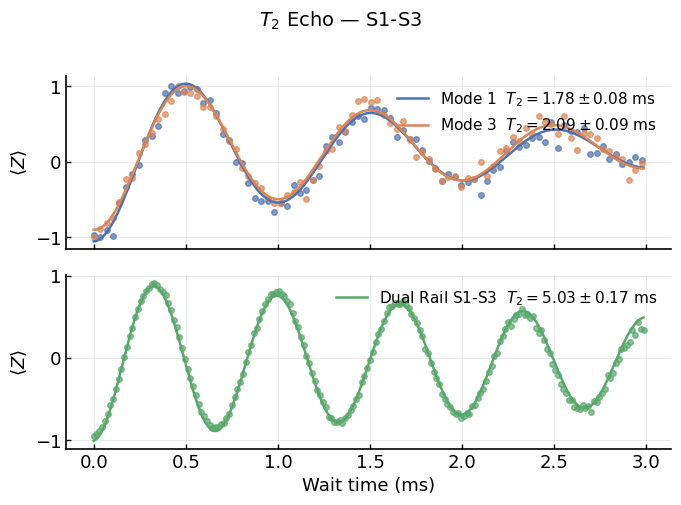

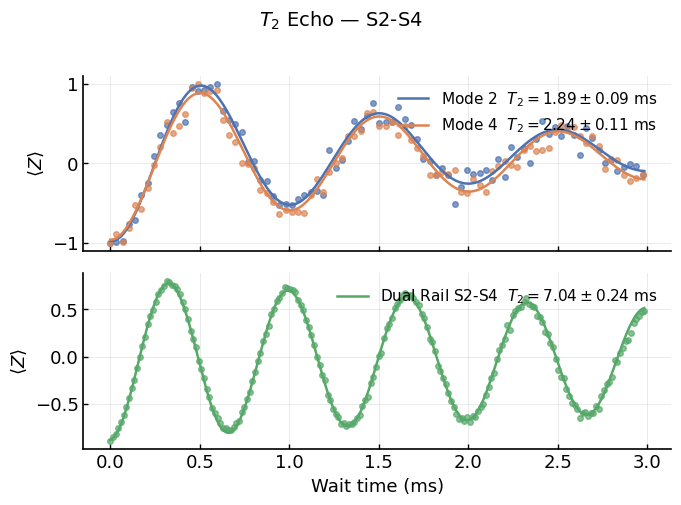

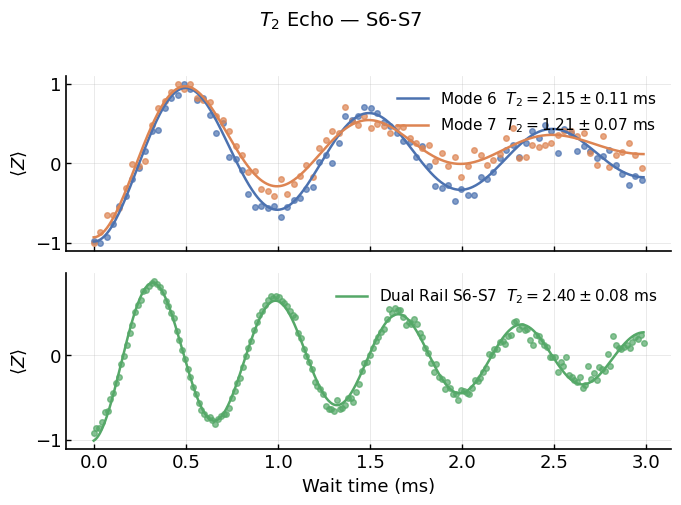

In [6]:
for idx, (mode1, mode2) in enumerate(dual_rail_modes):
    data_mode1, attrs_mode1 = prev_data(data_path, filename_t2_echo[idx*2])
    data_mode2, attrs_mode2 = prev_data(data_path, filename_t2_echo[idx*2+1])
    data_dual_rail, attrs_dual_rail = prev_data(data_path, filename_dual_rail_echo[idx])

    x_mode1 = data_mode1['xpts']
    x_mode2 = data_mode2['xpts']
    x_dual_rail = data_dual_rail['xpts']

    y_mode1 = data_mode1['avgi']
    y_mode2 = data_mode2['avgi']
    y_dr_10_0 = data_dual_rail['p_0_10']
    y_dr_10_1 = data_dual_rail['p_1_10']

    # rescale the mode 1 and mode 2 to be between -1 and 1
    y_mode1 = (y_mode1 - np.min(y_mode1)) / (np.max(y_mode1) - np.min(y_mode1)) * 2 - 1
    y_mode2 = (y_mode2 - np.min(y_mode2)) / (np.max(y_mode2) - np.min(y_mode2)) * 2 - 1

    y_dual_rail = y_dr_10_0 * 2 - 1

    # Refit cavity mode data (6-param decaysin, same as RamseyFitting.analyze)
    pOpt_m1, pCov_m1 = fitter.fitdecaysin(x_mode1, y_mode1)
    pOpt_m2, pCov_m2 = fitter.fitdecaysin(x_mode2, y_mode2)

    # Refit dual rail data (5-param decaysin1, same as DualRailRamseyExperiment.analyze)
    pOpt_dr, pCov_dr = fitter.fitdecaysin(x_dual_rail, y_dual_rail, use_x0=False)

    # Convert T2 values from us to ms
    T2_m1 = pOpt_m1[3] / 1e3
    T2_m1_err = np.sqrt(pCov_m1[3][3]) / 1e3
    T2_m2 = pOpt_m2[3] / 1e3
    T2_m2_err = np.sqrt(pCov_m2[3][3]) / 1e3
    T2_dr = pOpt_dr[3] / 1e3
    T2_dr_err = np.sqrt(pCov_dr[3][3]) / 1e3

    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

    x_max = min(x_mode1[-1], x_mode2[-1], x_dual_rail[-1])
    idx_mode_1 = np.where(x_mode1 <= x_max)
    idx_mode_2 = np.where(x_mode2 <= x_max)
    idx_dual_rail = np.where(x_dual_rail <= x_max)

    c1, c2, c_dr = COLORS['mode1'], COLORS['mode2'], COLORS['dual_rail']

    # --- Individual modes + fits ---
    ax[0].plot(x_mode1[idx_mode_1] / 1e3, y_mode1[idx_mode_1], 'o',
               color=c1, markersize=4, alpha=alpha_plot)
    ax[0].plot(x_mode2[idx_mode_2] / 1e3, y_mode2[idx_mode_2], 'o',
               color=c2, markersize=4, alpha=alpha_plot)

    x_fit = np.linspace(x_mode1[0], x_max, 500)
    ax[0].plot(x_fit / 1e3, fitter.decaysin(x_fit, *pOpt_m1), '-', color=c1, linewidth=1.8,
               label=f'Mode {mode1}  $T_2 = {T2_m1:.2f} \\pm {T2_m1_err:.2f}$ ms')
    x_fit2 = np.linspace(x_mode2[0], x_max, 500)
    ax[0].plot(x_fit2 / 1e3, fitter.decaysin(x_fit2, *pOpt_m2), '-', color=c2, linewidth=1.8,
               label=f'Mode {mode2}  $T_2 = {T2_m2:.2f} \\pm {T2_m2_err:.2f}$ ms')

    ax[0].legend(loc='upper right')
    ax[0].set_ylabel('$\\langle Z \\rangle$')

    # --- Dual rail + fit ---
    ax[1].plot(x_dual_rail[idx_dual_rail] / 1e3, y_dual_rail[idx_dual_rail], 'o',
               color=c_dr, markersize=4, alpha=alpha_plot)
    x_fit_dr = np.linspace(x_dual_rail[0], x_max, 500)
    ax[1].plot(x_fit_dr / 1e3, fitter.decaysin1(x_fit_dr, *pOpt_dr), '-', color=c_dr, linewidth=1.8,
               label=f'Dual Rail S{mode1}-S{mode2}  $T_2 = {T2_dr:.2f} \\pm {T2_dr_err:.2f}$ ms')

    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Wait time (ms)')
    ax[1].set_ylabel('$\\langle Z \\rangle$')

    fig.suptitle(f'$T_2$ Echo — S{mode1}-S{mode2}', fontsize=14, y=1.01)
    plt.tight_layout()


# Comparing the T1 of dual rail code to the T1 of the individual modes.

In [10]:
for idx, (mode1, mode2) in enumerate(dual_rail_modes[:2]):
    # everything is in the dual rail file 
    data_dual_rail, attrs_dual_rail = prev_data(data_path, filename_t1_dual_rail[idx])

In [12]:
data_dual_rail.keys()

dict_keys(['avgi_01_r1_w0', 'avgi_01_r1_w1020', 'avgi_01_r1_w1080', 'avgi_01_r1_w1140', 'avgi_01_r1_w120', 'avgi_01_r1_w1200', 'avgi_01_r1_w1260', 'avgi_01_r1_w1320', 'avgi_01_r1_w1380', 'avgi_01_r1_w1440', 'avgi_01_r1_w1500', 'avgi_01_r1_w1560', 'avgi_01_r1_w1620', 'avgi_01_r1_w1680', 'avgi_01_r1_w1740', 'avgi_01_r1_w180', 'avgi_01_r1_w1800', 'avgi_01_r1_w1860', 'avgi_01_r1_w1920', 'avgi_01_r1_w1980', 'avgi_01_r1_w2040', 'avgi_01_r1_w2100', 'avgi_01_r1_w2160', 'avgi_01_r1_w2220', 'avgi_01_r1_w2280', 'avgi_01_r1_w2340', 'avgi_01_r1_w240', 'avgi_01_r1_w2400', 'avgi_01_r1_w2460', 'avgi_01_r1_w2520', 'avgi_01_r1_w2580', 'avgi_01_r1_w2640', 'avgi_01_r1_w2700', 'avgi_01_r1_w2760', 'avgi_01_r1_w2820', 'avgi_01_r1_w2880', 'avgi_01_r1_w2940', 'avgi_01_r1_w300', 'avgi_01_r1_w3000', 'avgi_01_r1_w3060', 'avgi_01_r1_w3120', 'avgi_01_r1_w3180', 'avgi_01_r1_w3240', 'avgi_01_r1_w3300', 'avgi_01_r1_w3360', 'avgi_01_r1_w3420', 'avgi_01_r1_w3480', 'avgi_01_r1_w3540', 'avgi_01_r1_w360', 'avgi_01_r1_w3600

# General Analysis

For any experiment loaded from pickle, re-run analyze and display.

In [ ]:
expt.analyze()
expt.display()

# Dual Rail Sandbox Analysis

For `DualRailSandboxExperiment` results.

In [ ]:
expt.analyze(post_select=True)
expt.display(show_iq=True, show_histograms=True, log_scale=False)

# Dual Rail Ramsey Analysis

For `DualRailRamseyExperiment` results.

In [ ]:
expt.analyze(fit=True)
expt.display(fit=True, show_iq=False)

# Cavity Mode Ramsey Analysis

For `CavityModeRamseyExperiment` or `CavityRamseyExperiment` results.

In [ ]:
expt.analyze(fit=True)
expt.display(fit=True)

# Parity Phase Analysis

For `ParityPhaseExperiment` results.

In [ ]:
expt.analyze()
expt.display(fit=True, rescale=True)

# Custom Plotting

In [ ]:
fig, ax = plt.subplots()
ax.plot(expt.data['xpts'], expt.data['avgi'], '-o')
ax.set_xlabel('Sweep parameter')
ax.set_ylabel('Signal (a.u.)')
ax.set_title(type(expt).__name__)
plt.tight_layout()